In [1]:
import matplotlib.pyplot as plt
import fenics as fe

from nodal_basis.helpers import *

In [2]:
###### Section 1 ######
###### Calculation of the eigenpairs for the random field ###### 

# Inputs
# 5 takes 28 seconds
# 8 takes 4,5 minutes
mesh_resolution_c_entries = 5
randomFieldV, jacobianV = calculate_vector_field_eigenpairs(mesh_resolution_c_entries)

Building point search tree to accelerate distance queries.
Computed bounding box tree with 177 nodes for 89 points.
C: [[ 5.69564628e-04  2.63017680e-07 -3.92244802e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.63017680e-07  2.67352136e-04 -2.15055638e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.92244802e-05 -2.15055638e-04  3.27247557e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.72456646e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   6.95618962e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  3.21882676e-05]]


In [3]:
print(f"eigenvalues: {jacobianV.eigenvalues}")

eigenvalues: [2.78438689e-03 2.38906443e-03 2.34818395e-03 2.18849538e-03
 2.14422664e-03 2.09096271e-03 2.08496356e-03 2.03171925e-03
 2.00503119e-03 2.00339117e-03 1.97108562e-03 1.92073990e-03
 1.89581105e-03 1.65213610e-03 1.58351375e-03 1.57586984e-03
 1.45724831e-03 1.38955325e-03 1.33612007e-03 1.30867522e-03
 1.26744458e-03 1.15953577e-03 1.10575160e-03 8.91107193e-04
 8.35649802e-04 7.77190732e-04 7.48936679e-04 7.18308789e-04
 6.03980767e-04 5.79286140e-04 5.52341276e-04 5.19444040e-04
 4.63672422e-04 3.68757709e-04 3.42604746e-04 3.10056556e-04
 2.32267556e-04 2.11502047e-04 4.66681054e-05 4.59372008e-05
 3.28652749e-05 3.21306665e-05 3.10931577e-05 3.07098564e-05
 2.97732978e-05 2.34487670e-05 2.21936650e-05 2.00340818e-05
 1.25410984e-05 8.40900364e-06 4.17519797e-18 4.17519797e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


Iteration 1/1
Solving linear variational problem.


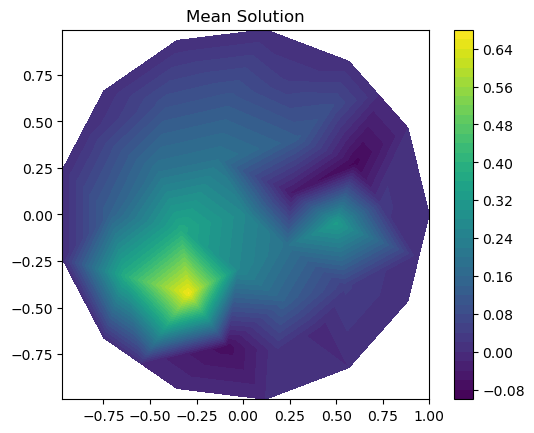

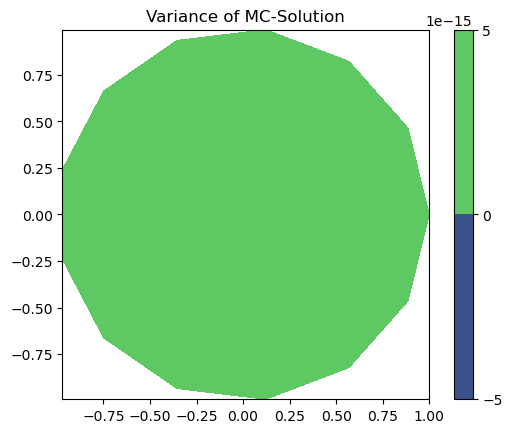

In [5]:
###### Section 2 ######
###### Single MC-loop Calculation of samples of the vector field saved globally ######

# Inputs
# 1 sample with resolution 3 takes approx. 2,2 minutes if mesh_resolution_c_entries = 5
# 1 samples with resolution 4 takes approx. 4 minutes if mesh_resolution_c_entries = 5
mc_samples_single = 1
mesh_resolution_fem_single = 4

# Calling the function
mean_sol, var_sol = mc_single_global_calculation(mc_samples_single, mesh_resolution_fem_single, jacobianV)

#Plots
c = fe.plot(mean_sol, title='Mean Solution')
plt.colorbar(c)
plt.show()

c = fe.plot(var_sol, title='Variance of MC-Solution')
plt.colorbar(c)
plt.show()

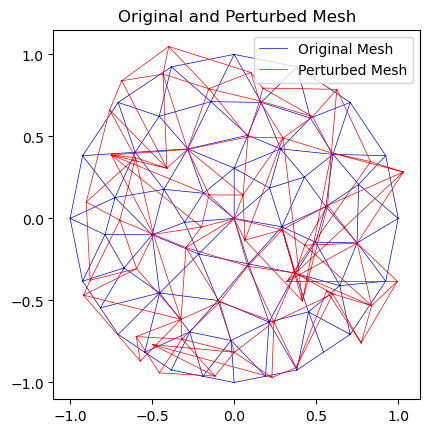

In [10]:
xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), jacobianV.J)
mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_c_entries)
# perturbed mesh based on the "original" mesh used for the KL-expansion
perturbed_coordinates = mesh.coordinates().copy()
for index, coordinate in enumerate(mesh.coordinates()):
    perturbed_coordinates[index] = randomFieldV(coordinate, xi)
# Create a new mesh with the perturbed coordinates
perturbed_mesh = fe.Mesh(mesh)
perturbed_mesh.coordinates()[:] = perturbed_coordinates

# Plot the original mesh and the perturbed mesh in one figure with different colors
plt.figure()
fe.plot(mesh, color='blue', linewidth=0.5, label='Original Mesh')
fe.plot(perturbed_mesh, color='red', linewidth=0.5, label='Perturbed Mesh')
plt.legend()
plt.title(f"Original and Perturbed Mesh")
plt.show()

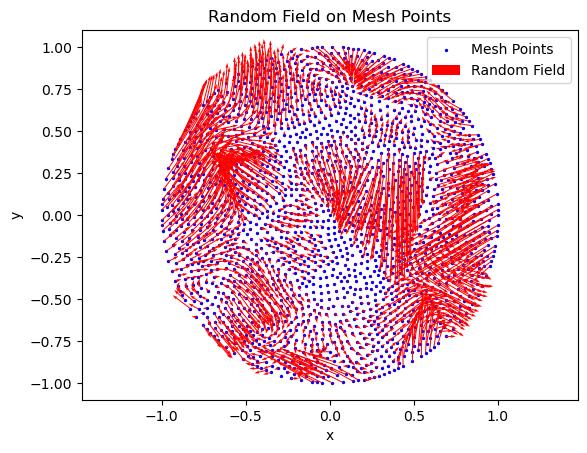

In [12]:
fine_mesh_resolution = 32 # 32 takes approx. 2,5 minutes for mesh_resolution_c_entries = 5
fine_mesh_coordinates = mshr.generate_mesh(DOMAIN, fine_mesh_resolution).coordinates()
random_field_values = np.array([randomFieldV(coord.copy(), xi) for coord in fine_mesh_coordinates])
plt.figure()
plt.scatter(fine_mesh_coordinates[:, 0], fine_mesh_coordinates[:, 1], color='blue', s=2, label='Mesh Points')
plt.quiver(fine_mesh_coordinates[:, 0], fine_mesh_coordinates[:, 1], 
           random_field_values[:, 0] - fine_mesh_coordinates[:, 0], 
           random_field_values[:, 1] - fine_mesh_coordinates[:, 1], 
           color='red', scale=1, scale_units='xy', angles='xy', width=0.002, label='Random Field')
plt.title("Random Field on Mesh Points")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()

In [14]:
###### Section 3 ######
###### Multiple MC-loop Calculation of samples of the vector field local analysis ######

# Inputs
# [1, 2, 4], 5, 5 takes approximately 7 minutes
# [2, 4, 8, 16], 4, 6 takes approximately 20 minutes
# [1, 2, 4, 8, 16], 5, 5 takes approximately 72 minutes
# [1, 2, 4, 8, 16, 32, 64], 5, 5 takes approximately 370 minutes
mc_samples_multiple = [1, 2, 4, 8, 16, 32, 64]
mesh_resolution_fem_multiple = 5
mesh_resolution_fem_true_sol = 5
P = fe.Point(0, 0)

# Calculate samples and solutions
u_sols_in_point_P_mean, u_sols_in_point_P_var, L_2_errors, H_1_errors, u_true_sol_P = mc_multiple_local_calculation(mc_samples_multiple, mesh_resolution_fem_multiple, mesh_resolution_fem_true_sol, P, jacobianV)

# Plot
plt.figure(figsize=(15, 10))

# Mean value plot
plt.subplot(2, 2, 1)
plt.plot(mc_samples_multiple, u_sols_in_point_P_mean, marker='o')
plt.axhline(y=u_true_sol_P, color='r', linestyle='--', label=f'True solution at point x=({P.x()}, {P.y()})')
plt.xscale('log')
plt.title('Mean Value at Point P')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('Mean Value')

# Variance plot
plt.subplot(2, 2, 2)
plt.plot(mc_samples_multiple, u_sols_in_point_P_var, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('Variance at Point P')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('Variance (log scale)')

# L2 error plot
plt.subplot(2, 2, 3)
plt.plot(mc_samples_multiple, L_2_errors, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('L2 Error')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('L2 Error (log scale)')

# H1 error plot
plt.subplot(2, 2, 4)
plt.plot(mc_samples_multiple, H_1_errors, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('H1 Error')
plt.xlabel('Monte Carlo Sample Size (log scale)')
plt.ylabel('H1 Error (log scale)')

plt.tight_layout()
plt.show()

Solving linear variational problem.Iteration 1/1

Solving linear variational problem.


KeyboardInterrupt: 